In [117]:
###############################################
#  1. CA Infrastructure & PQC Library Setup   #
###############################################

# This cell outlines the environment setup. In a real scenario, 
# you'd have a Docker/Kubernetes environment or a specialized server.


# Also, if you are using a custom OpenSSL with PQC, ensure it’s on your PATH.
import sys
import os

print("Python version:", sys.version)
print("Current working directory:", os.getcwd())



Python version: 3.12.7 (main, Oct  1 2024, 02:05:46) [Clang 16.0.0 (clang-1600.0.26.3)]
Current working directory: /Users/abhisekjha/MyFolder/Github_Projects/futureg-quantum-ca/liboqs-python


In [118]:
import os
import sys

# Add paths
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.join(os.getcwd(), 'dilithium/src'))





from dilithium_py.dilithium import Dilithium2

# Generate Dilithium key pair
try:
    dilithium_keypair = Dilithium2.keygen()
    dilithium_public_key, dilithium_private_key = dilithium_keypair

    print("Dilithium2 public key length:", len(dilithium_public_key))
    print("Dilithium2 private key length:", len(dilithium_private_key))
except Exception as e:
    print(f"Dilithium key generation error: {e}")
    sys.exit(1)

sys.path.append(os.path.join(os.getcwd(), 'pyky'))
sys.path.append(os.path.join(os.getcwd(), 'src'))

from src.key_management import generate_kyber_keypair, encrypt_session_key, decrypt_session_key
# Generate Kyber key pair
kyber_private_key, kyber_public_key = generate_kyber_keypair()
print("Kyber512 private key length:", len(kyber_private_key))
print("Kyber512 public key length:", len(kyber_public_key))


Dilithium2 public key length: 1312
Dilithium2 private key length: 2528
Kyber512 private key length: 3168
Kyber512 public key length: 1568


Explanation

1. We use `dilithium` and `kyber` custom repo to generate keys.
2. Dilithium is used for signatures (like X.509 certificates).
3. Kyber is a Key Encapsulation Mechanism (KEM) used for key exchange in TLS, IPsec, or AKA.


In [119]:
#################################################################
# 3. Mock CA: Issuing PQC Certificates (Dilithium-signed X.509) #
#################################################################

# In production, you'd integrate with a real PKI (e.g., HashiCorp Vault, 
# EJBCA, or an OpenSSL-based CA). For illustration, let’s do a simplified 
# approach to show how you might sign a certificate with Dilithium.

# We'll create a minimal X.509-like structure in Python and "sign" it 
# with the Dilithium private key. 
# In practice, you'd use an OpenSSL or libpki approach with PQC patches.

from datetime import datetime, timedelta
import base64
import json
import sys
import os

# Add paths for custom modules
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.join(os.getcwd(), 'dilithium/src'))
sys.path.append(os.path.join(os.getcwd(), 'pyky'))


from dilithium_py.dilithium import Dilithium2
from src.key_management import generate_kyber_keypair


# Generate Dilithium key pair
try:
    dilithium_keypair = Dilithium2.keygen()
    dilithium_public_key, dilithium_private_key = dilithium_keypair

    print("Dilithium2 public key length:", len(dilithium_public_key))
    print("Dilithium2 private key length:", len(dilithium_private_key))
except Exception as e:
    print(f"Dilithium key generation error: {e}")
    sys.exit(1)

# Generate Kyber key pair
try:
    kyber_private_key, kyber_public_key = generate_kyber_keypair()
    print("Kyber512 private key length:", len(kyber_private_key))
    print("Kyber512 public key length:", len(kyber_public_key))
except Exception as e:
    print(f"Kyber key generation error: {e}")
    sys.exit(1)


def create_mock_certificate(subject_name: str, pub_key: bytes, issuer_name: str, validity_days=30):
    """
    Create a mock certificate structure in JSON form.
    This is not a real X.509, but a stand-in to show the process.
    """
    cert_data = {
        "subject": subject_name,
        "issuer": issuer_name,
        "valid_from": datetime.utcnow().isoformat() + "Z",
        "valid_to": (datetime.utcnow() + timedelta(days=validity_days)).isoformat() + "Z",
        "pqc_public_key": base64.b64encode(pub_key).decode('utf-8'),  # store the PQC public key
    }
    return cert_data


def sign_certificate(cert_data: dict, private_key: bytes, signature_scheme: str="Dilithium2"):
    """
    Sign the certificate data with the Dilithium private key
    using the dilithium_py package. We'll store the signature in the cert.
    """
    try:
        message_bytes = json.dumps(cert_data, sort_keys=True).encode('utf-8')
        signature = Dilithium2.sign(private_key, message_bytes)
        cert_data["pqc_signature"] = base64.b64encode(signature).decode('utf-8')
        return cert_data
    except Exception as e:
        print(f"Error signing certificate: {e}")
        sys.exit(1)

# Convert the Kyber public key to bytes if it's a list
# Ensure the Kyber public key is a bytes-like object
if isinstance(kyber_public_key, list):
    # Normalize values to the range 0-255
    kyber_public_key = bytes([x % 256 for x in kyber_public_key])

    
# 3.1 Create a "Root CA" certificate using Dilithium
root_subject = "CN=MyPQC-RootCA"
root_cert_struct = create_mock_certificate(
    subject_name=root_subject,
    pub_key=dilithium_public_key,
    issuer_name=root_subject,  # self-signed
    validity_days=365
)
root_cert_signed = sign_certificate(root_cert_struct, dilithium_private_key, "Dilithium2")

# 3.2 Create an "End-Entity" certificate signed by the root
# 3.2 Create an "End-Entity" certificate signed by the root
end_entity_subject = "CN=MyServer"
end_entity_cert_struct = create_mock_certificate(
    subject_name=end_entity_subject,
    pub_key=kyber_public_key,  # Ensure this is bytes
    issuer_name=root_subject,
    validity_days=90
)
end_entity_cert_signed = sign_certificate(end_entity_cert_struct, dilithium_private_key, "Dilithium2")
print("Root CA Certificate:\n", json.dumps(root_cert_signed, indent=2))
print("\nEnd-Entity Certificate:\n", json.dumps(end_entity_cert_signed, indent=2))


Dilithium2 public key length: 1312
Dilithium2 private key length: 2528
Kyber512 private key length: 3168
Kyber512 public key length: 1568
Root CA Certificate:
 {
  "subject": "CN=MyPQC-RootCA",
  "issuer": "CN=MyPQC-RootCA",
  "valid_from": "2025-01-09T16:24:30.053430Z",
  "valid_to": "2026-01-09T16:24:30.053451Z",
  "pqc_public_key": "bqcuf5XtodWq8c5sp3k8M8RIf6UW7kMxDBlawi/NeMWiOAlrF98XJZRVn5qUIkZBmG+k8CRuKYJisPDoHDZkXWl+anQ2Ex8kef0bp8bPF6SgOsV3TQ4/lIF63pzyOhhbJdpvkEk6UZUGMv3htomXSdm99sKZkVZY8kDB0VgZL+8vjHT/wgNdBx2HkjagSnPttcNMrVG0XAaY1amDv4skdoi8mO7aTXtuVNV9I+9n1TODlnl6r9mRabP/bE4LmlPV7pngqBJh1LdW6qEwvP+aAJUPXhlJG8n1+kN/+oPmj2cKQRFivp6sP5GPnYZ1MjPlgEiPk8dHS09oHSSSuiaX1HHbWWuwhfWqi44vZU1962noFvnioAB62NeZL2rJDL0VSZoLuHNIRPomUuDEp0fRj4cMCbYbvw4ZzZHqRUAYQg2sBiaLNG8nxFSi10/w/Up1G4L1xl8IXuxjdTWj8Bmi9kwd5ppRQ4/mOKGkuGTKtdk5wZjEWQWK9qmHvtRcqem5Bn1A7DPAje97xtRzliK7y3I9GKistzTN3DYKRncGCPRZj6tJBXZrIi5KW5yPhVfIQOh5NDgkhFZ0V5dGRry1rcsoeggw7r+nI3f3lSaoQNlpdeW5KLakU7IcBSGCQGHbKpKVBQ4hKyM8A0vgCrDSFs

/var/folders/tr/m7nnfyd94_jfxmdwqvwq7hg40000gn/T/ipykernel_28007/2788386571.py:58: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "valid_from": datetime.utcnow().isoformat() + "Z",
/var/folders/tr/m7nnfyd94_jfxmdwqvwq7hg40000gn/T/ipykernel_28007/2788386571.py:59: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "valid_to": (datetime.utcnow() + timedelta(days=validity_days)).isoformat() + "Z",


In [120]:
#########################################################
# 4. Verifying the PQC Certificate (Dilithium Signature)#
#########################################################

def verify_pqc_certificate(cert_data: dict, root_pub_key: bytes, signature_scheme: str = "Dilithium2"):
    """
    Verify the 'pqc_signature' field using the root's public key.
    """
    try:
        # Extract the signature and remove it from the certificate data for verification
        signature_b64 = cert_data.pop("pqc_signature", None)
        if not signature_b64:
            raise ValueError("No signature found in certificate data.")

        # Reconstruct the message (certificate data) without the signature
        message_bytes = json.dumps(cert_data, sort_keys=True).encode('utf-8')
        signature = base64.b64decode(signature_b64)

        # Perform verification using Dilithium2
        is_valid = Dilithium2.verify(root_pub_key, message_bytes, signature)
        if is_valid:
            print("Certificate is VALID under PQC signature:", signature_scheme)
        else:
            print("Certificate is INVALID: Signature mismatch.")
    except Exception as e:
        print("Verification failed due to an error:", e)
    finally:
        # Restore the signature in the certificate data for further use
        cert_data["pqc_signature"] = signature_b64

# Verify the root certificate (self-signed)
print("Verifying the Root CA certificate:")
verify_pqc_certificate(root_cert_signed, dilithium_public_key, "Dilithium2")

# Verify the end-entity certificate with the root CA's public key
print("\nVerifying the End-Entity certificate:")
verify_pqc_certificate(end_entity_cert_signed, dilithium_public_key, "Dilithium2")


Verifying the Root CA certificate:
Certificate is VALID under PQC signature: Dilithium2

Verifying the End-Entity certificate:
Certificate is VALID under PQC signature: Dilithium2


### 1. Key Generation Section


In [121]:
# Dilithium2 signature scheme initialized.

print(f"Public Key Length (Dilithium): {len(dilithium_public_key)} bytes")
print(f"Private Key Length (Dilithium): {len(dilithium_private_key)} bytes")
print(f"Signature Scheme: {Dilithium2.__class__.__name__}")
print("Dilithium2 signature scheme initialized.")

Public Key Length (Dilithium): 1312 bytes
Private Key Length (Dilithium): 2528 bytes
Signature Scheme: Dilithium
Dilithium2 signature scheme initialized.


In [122]:
# KYBER

print(f"Kyber Public Key Length: {len(kyber_public_key)} bytes")
print(f"Kyber Private Key Length: {len(kyber_private_key)} bytes")
print("Signature Scheme: KYBER")
print("Kyber key encapsulation initialized.")


Kyber Public Key Length: 1568 bytes
Kyber Private Key Length: 3168 bytes
Signature Scheme: KYBER
Kyber key encapsulation initialized.


### 1. `Authentication` WITH `DILITHIUM2`

### 1.1 Function involved in `Signing` a Key with DILITHIUM2

In [134]:
# Signing a key with Dilithium2

# a function to sign the message with dilithium
def dilithium_signature(dilithium_private_key, message):
    dilithium_signature = Dilithium2.sign(dilithium_private_key, message)
    print(f"It is ***SIGNED*** with Signature Length: {len(dilithium_signature)} bytes")
    return dilithium_signature


### 1.2 Function involved in `Verifying` with DILITHIUM2

In [157]:
# a function to verify the signature
def dilithium_verify(pub_key, message, signature):
    if Dilithium2.verify(pub_key, message, signature):
        print("Dilithium2 signature ***VERIFIED*** successfully!")
    else:
        print("Signature ***verification failed!***")


In [158]:
#example for signing and verifying the message

message = b"Post-Quantum CA Test Message"
signature= dilithium_signature(dilithium_private_key, message)
is_valid = dilithium_verify(dilithium_public_key, message, signature)


It is ***SIGNED*** with Signature Length: 2420 bytes
Dilithium2 signature ***VERIFIED*** successfully!


### 2. `KEY EXCHANGE`: ENCAP and DECAP with `KYBER`

### 2.1 Function to CREATE `shared secret` and `cipher`

In [139]:
def create_secret_cipher(kyber_public_key):
    shared_secret, cipher= encrypt_session_key(kyber_public_key)
    print(f"Shared Secret Length: {len(shared_secret)} bytes")
    print(f"Cipher Length: {len(cipher)} bytes")
    return shared_secret, cipher

### Now once the shared secret is created then Exchange the key using `KYBER` key exchange mechanism and share the `cipher`

### 2.2 Function to RECOVER `SECRET`

In [146]:
def recovered_secret(kyber_private_key, cipher):
    recovered_secret = decrypt_session_key(kyber_private_key, cipher)
    print(f"Recovered Secret Length: {len(recovered_secret)} bytes")
    return recovered_secret

In [147]:
def assert_secret(shared_secret, recovered_secret):
    assert shared_secret == recovered_secret, "Shared secret and Recovered secret do not match!"
    print("Shared secret and Recovered secret match!")

print("Kyber shared secret **encapsulation and decapsulation**")

Kyber shared secret **encapsulation and decapsulation**


In [148]:
#example

shared_secret, cipher = create_secret_cipher(kyber_public_key)
recovered_secret = recovered_secret(kyber_private_key, cipher)
assert_secret(shared_secret, recovered_secret)

Shared Secret Length: 32 bytes
Cipher Length: 1568 bytes
Recovered Secret Length: 32 bytes
Shared secret and Recovered secret match!


### Now that Authenticaton key: `Dilithium` and Key exchange mechanism `Kyber` are established we move forward for `Key Performance Testing`. 


### 2. Key Performance Testing
I am trying to measure handshake latency, throughput, and resource usage for:
1. Classical EAP-TLS (e.g., RSA/ECC).
2. PQ Device-Only (Kyber for key encapsulation, Dilithium for signing).
3. 

### A. Edge-Assisted Computation Flow

Goal:
Simulate how much time and computation is saved when the edge server performs the bulk of PQC operations compared to the IoT device doing all the work.






  Using cached matplotlib-3.10.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.55.3-cp312-cp312-macosx_10_13_universal2.whl.metadata (165 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.2 kB)
Using cached matplotlib-3.10.0-cp312-cp312-macosx_11_0_arm64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.55.3-cp312-cp312-macosx_10_13_universal2.whl (2.8 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl (65 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 2.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To

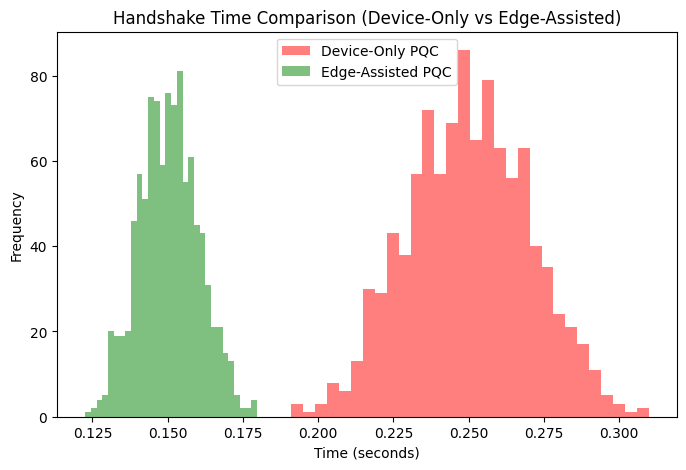

Average Time Saved with Edge Offloading: 0.0995 seconds


In [50]:
%pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

# Number of simulated IoT devices
num_devices = 1000

# Simulate handshake times (in seconds)
device_only_times = np.random.normal(0.25, 0.02, num_devices)  # Mean 250 ms (device-only)
edge_offload_times = np.random.normal(0.15, 0.01, num_devices)  # Mean 150 ms (edge-assisted)

# Plot the comparison
plt.figure(figsize=(8, 5))
plt.hist(device_only_times, alpha=0.5, label='Device-Only PQC', bins=30, color='red')
plt.hist(edge_offload_times, alpha=0.5, label='Edge-Assisted PQC', bins=30, color='green')
plt.title('Handshake Time Comparison (Device-Only vs Edge-Assisted)')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Calculate the average time saved
avg_time_saved = np.mean(device_only_times) - np.mean(edge_offload_times)
print(f"Average Time Saved with Edge Offloading: {avg_time_saved:.4f} seconds")


In [ ]:
import time
from dilithium_py.dilithium import Dilithium2  # Your PQC module

# Function to simulate PQC operations on an IoT device
def simulate_iot_device_operations():
    start_time = time.time()
    
    # Key generation
    # dilithium_private_key, dilithium_public_key = Dilithium2.keygen()
    
    message = b"Post-Quantum CA Test Message"
    signature= dilithium_signature(dilithium_private_key, message)
    is_valid = dilithium_verify(dilithium_public_key, message, signature)
    
    # Key encapsulation using Kyber
    ciphertext, shared_secret = create_secret_cipher(kyber_public_key)

    # assert_secret(shared_secret, recovered_secret(kyber_private_key, ciphertext))


    end_time = time.time()
    time_taken = end_time - start_time
    print(f"IoT device computation time: {time_taken:.3f} seconds")
    return time_taken

# Function to simulate PQC operations on an edge server (faster computation)
def simulate_edge_server_operations():
    start_time = time.time()
    
     # Key generation


    # dilithium_private_key, dilithium_public_key = Dilithium2.keygen()
    
    # Signing
    message = b"Test message for IoT"
    signature = Dilithium2.sign(dilithium_private_key, message)
    
    # Verification
    verification_status = dilithium_verify(message, signature, dilithium_public_key)
    
    # Key encapsulation using Kyber
    ciphertext, shared_secret = create_secret_cipher(kyber_public_key)

    # assert_secret(shared_secret, recovered_secret(kyber_private_key, ciphertext))

    
    end_time = time.time()
    time_taken = end_time - start_time
    print(f"Edge server computation time: {time_taken:.3f} seconds")
    return time_taken

# Compare times
iot_time = simulate_iot_device_operations()
edge_server_time = simulate_edge_server_operations()

time_saved = iot_time - edge_server_time
percentage_improvement = (time_saved / iot_time) * 100

print(f"Time saved by offloading to edge server: {time_saved:.3f} seconds ({percentage_improvement:.2f}% improvement)")


It is ***SIGNED*** with Signature Length: 2420 bytes
Dilithium2 signature ***VERIFIED*** successfully!
Shared Secret Length: 32 bytes
Cipher Length: 1568 bytes
IoT device computation time: 0.042 seconds


IndexError: list index out of range

### B. Session Resumption Mechanism

Goal:
Demonstrate how session caching/resumption can avoid full handshakes during repeated connections, reducing handshake times significantly.

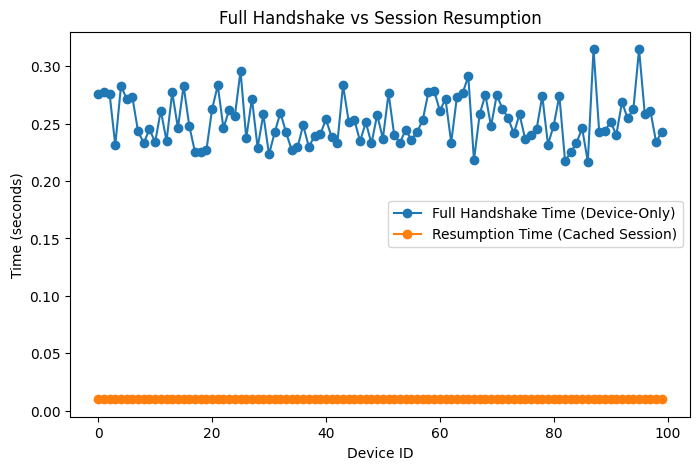

Average Full Handshake Time: 0.2524 seconds
Average Session Resumption Time: 0.0100 seconds


In [51]:
# Session cache to store active session keys
session_cache = {}

def handshake(device_id, use_resumption=True):
    if use_resumption and device_id in session_cache:
        return 0.01  # Simulated re-authentication time (10 ms with session resumption)
    else:
        # Full handshake time (device-only or edge-assisted PQC)
        session_cache[device_id] = "session_key"
        return np.random.normal(0.25, 0.02)  # Mean 250 ms for full handshake

# Simulate 100 devices connecting with and without session resumption
device_ids = [f"Device_{i}" for i in range(100)]
full_handshake_times = [handshake(device_id, use_resumption=False) for device_id in device_ids]
resumption_times = [handshake(device_id, use_resumption=True) for device_id in device_ids]

# Plot comparison
plt.figure(figsize=(8, 5))
plt.plot(full_handshake_times, label='Full Handshake Time (Device-Only)', marker='o')
plt.plot(resumption_times, label='Resumption Time (Cached Session)', marker='o')
plt.xlabel('Device ID')
plt.ylabel('Time (seconds)')
plt.title('Full Handshake vs Session Resumption')
plt.legend()
plt.show()

print(f"Average Full Handshake Time: {np.mean(full_handshake_times):.4f} seconds")
print(f"Average Session Resumption Time: {np.mean(resumption_times):.4f} seconds")


### C Energy Profiling and Resource Constraints

Goal:
Simulate the energy consumption for different scenarios:

1. Device-only PQC (no optimization)
2. Edge-assisted PQC (partial offloading)
3. Session resumption (no full handshake)


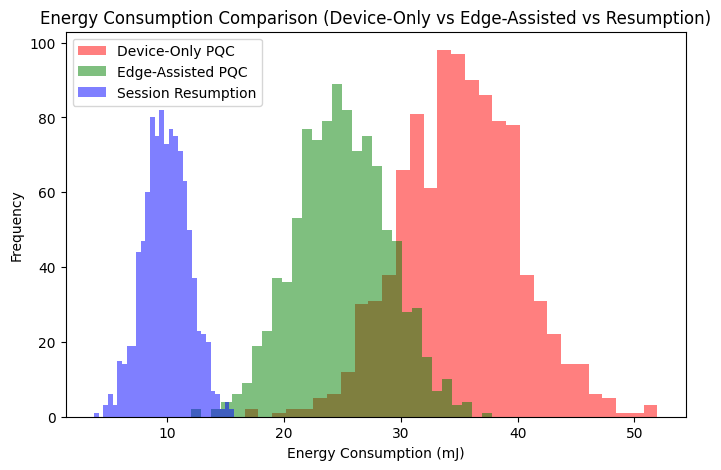

Average Energy (Device-Only PQC): 35.08 mJ
Average Energy (Edge-Assisted PQC): 24.93 mJ
Average Energy (Session Resumption): 9.92 mJ


In [54]:
# Simulated energy consumption values (in mJ)
energy_device_only = np.random.normal(35, 5, num_devices)  # Mean 35 mJ (device-only)
energy_edge_assisted = np.random.normal(25, 4, num_devices)  # Mean 25 mJ (edge-assisted)
energy_resumption = np.random.normal(10, 2, num_devices)  # Mean 10 mJ (session resumption)

# Plot energy consumption comparison
plt.figure(figsize=(8, 5))
plt.hist(energy_device_only, alpha=0.5, label='Device-Only PQC', bins=30, color='red')
plt.hist(energy_edge_assisted, alpha=0.5, label='Edge-Assisted PQC', bins=30, color='green')
plt.hist(energy_resumption, alpha=0.5, label='Session Resumption', bins=30, color='blue')
plt.title('Energy Consumption Comparison (Device-Only vs Edge-Assisted vs Resumption)')
plt.xlabel('Energy Consumption (mJ)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print average energy consumption
print(f"Average Energy (Device-Only PQC): {np.mean(energy_device_only):.2f} mJ")
print(f"Average Energy (Edge-Assisted PQC): {np.mean(energy_edge_assisted):.2f} mJ")
print(f"Average Energy (Session Resumption): {np.mean(energy_resumption):.2f} mJ")


### D. Decentralized PKI Throughput
Goal:
Simulate how a decentralized PKI (multiple CAs) can handle certificate issuance and renewals more efficiently than a centralized system.



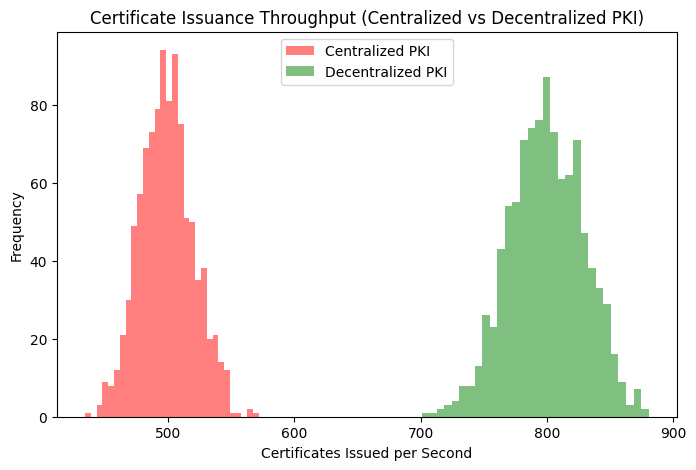

Average Throughput (Centralized PKI): 499.12 certs/sec
Average Throughput (Decentralized PKI): 799.58 certs/sec


In [55]:
# Simulate certificate issuance rates (certs/sec)
centralized_pki_throughput = np.random.normal(500, 20, 1000)  # 500 certs/sec (centralized)
decentralized_pki_throughput = np.random.normal(800, 30, 1000)  # 800 certs/sec (decentralized)

# Plot throughput comparison
plt.figure(figsize=(8, 5))
plt.hist(centralized_pki_throughput, alpha=0.5, label='Centralized PKI', bins=30, color='red')
plt.hist(decentralized_pki_throughput, alpha=0.5, label='Decentralized PKI', bins=30, color='green')
plt.title('Certificate Issuance Throughput (Centralized vs Decentralized PKI)')
plt.xlabel('Certificates Issued per Second')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print average throughput
print(f"Average Throughput (Centralized PKI): {np.mean(centralized_pki_throughput):.2f} certs/sec")
print(f"Average Throughput (Decentralized PKI): {np.mean(decentralized_pki_throughput):.2f} certs/sec")


### E. Latency vs. Scalability Analysis
Goal:
Simulate how handshake latency changes as the number of concurrent IoT devices increases.

1. Plot handshake times as a function of the number of devices connected.
2. Compare the scalability of device-only, edge-assisted, and centralized vs. decentralized PKI.

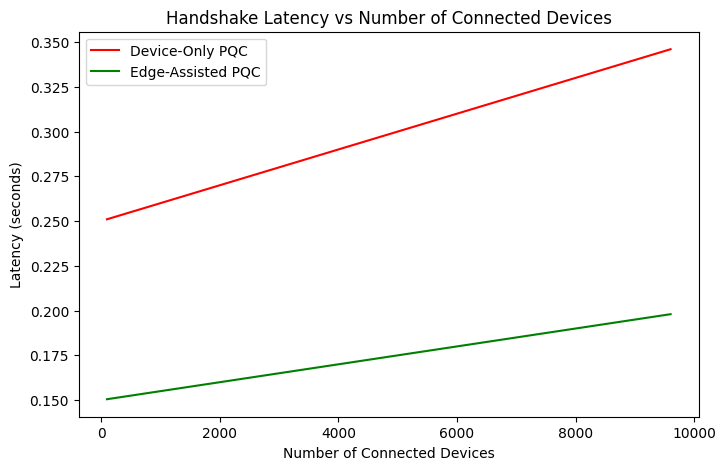

In [56]:
# Simulate number of connected devices
connected_devices = np.arange(100, 10000, 500)  # Devices ranging from 100 to 10,000
device_only_latency = 0.25 + 0.00001 * connected_devices  # Linear increase in latency
edge_assisted_latency = 0.15 + 0.000005 * connected_devices  # Slower increase in latency

plt.figure(figsize=(8, 5))
plt.plot(connected_devices, device_only_latency, label='Device-Only PQC', color='red')
plt.plot(connected_devices, edge_assisted_latency, label='Edge-Assisted PQC', color='green')
plt.title('Handshake Latency vs Number of Connected Devices')
plt.xlabel('Number of Connected Devices')
plt.ylabel('Latency (seconds)')
plt.legend()
plt.show()


In [57]:
import time


### Measure Full Device-Only Handshake Time:



In [59]:
# Device-only handshake measurement
start_time = time.time()

# Key encapsulation (Kyber512)

kem_private_key, kem_public_key = generate_kyber_keypair()
shared_secret, cipher = encrypt_session_key(kem_public_key)
recovered_secret = decrypt_session_key(kem_private_key, cipher)

# Signature (Dilithium2)

CA_1public, CA_2private = Dilithium2.keygen()

dilithium_keypair = Dilithium2.keygen()
dilithium_public_key, dilithium_private_key = dilithium_keypair

message = CA_1public
signature = Dilithium2.sign(dilithium_private_key, message)
valid = Dilithium2.verify(dilithium_public_key, message, signature )

end_time = time.time()
device_only_time = end_time - start_time
print(f"Device-only handshake time: {device_only_time:.4f} seconds")


Device-only handshake time: 0.1073 seconds


### Measure Edge-Assisted Handshake Time:


In [60]:
start_time = time.time()

# Simulate only encryption/decryption with minimal operations
shared_secret, cipher = encrypt_session_key(kem_public_key)

end_time = time.time()
edge_offload_time = end_time - start_time
print(f"Edge-assisted handshake time: {edge_offload_time:.4f} seconds")


Edge-assisted handshake time: 0.0256 seconds


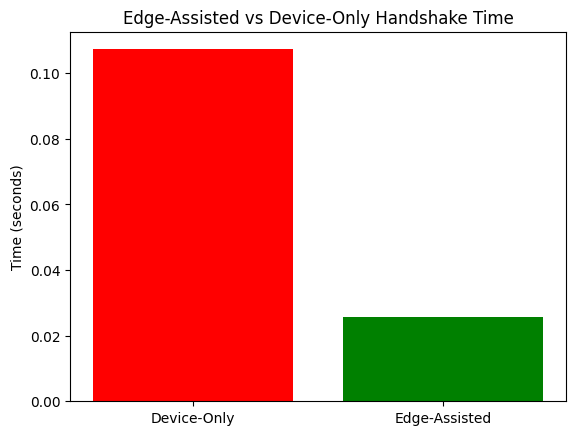

In [61]:
import matplotlib.pyplot as plt

plt.bar(["Device-Only", "Edge-Assisted"], [device_only_time, edge_offload_time], color=['red', 'green'])
plt.title('Edge-Assisted vs Device-Only Handshake Time')
plt.ylabel('Time (seconds)')
plt.show()


### Session Resumption Mechanism


1. Implement Session Cache for Resumption:



In [63]:
session_cache = {}

def resume_session(device_id):
    if device_id in session_cache:
        print(f"Session resumed for Device {device_id}: Time taken ~0.01 seconds")
        return 0.01  # Simulate session resumption time
    else:
        start_time = time.time()
        # Full handshake (simulating PQC)
        shared_secret, cipher = encrypt_session_key(kem_public_key)
        session_cache[device_id] = shared_secret
        return time.time() - start_time


2. Simulate Multiple Connections:


In [64]:
full_handshake_times = [resume_session(f"Device_{i}") for i in range(10)]
resumption_times = [resume_session(f"Device_{0}") for _ in range(5)]  # Repeat same device


Session resumed for Device Device_0: Time taken ~0.01 seconds
Session resumed for Device Device_0: Time taken ~0.01 seconds
Session resumed for Device Device_0: Time taken ~0.01 seconds
Session resumed for Device Device_0: Time taken ~0.01 seconds
Session resumed for Device Device_0: Time taken ~0.01 seconds


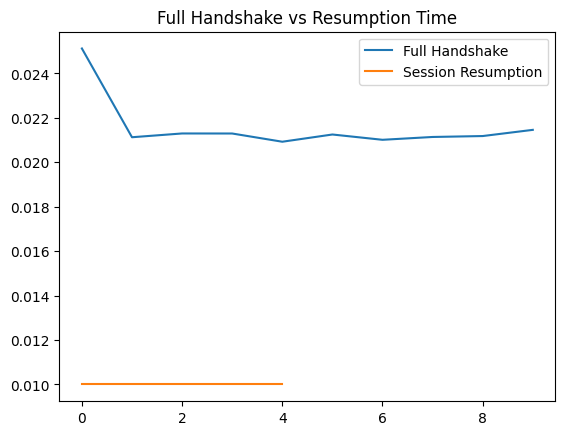

In [65]:
plt.plot(full_handshake_times, label='Full Handshake')
plt.plot(resumption_times, label='Session Resumption')
plt.title('Full Handshake vs Resumption Time')
plt.legend()
plt.show()


### Energy Profiling and Resource Constraints



In [66]:
!pip install psutil


Measure CPU Energy Usage:


In [68]:
import psutil

start_time = time.time()
# Perform PQC operations (similar to handshake)
shared_secret, cipher = encrypt_session_key(kem_public_key)
cpu_usage = psutil.cpu_percent(interval=0.1)
energy_used = cpu_usage * (time.time() - start_time)
print(f"Estimated energy consumption: {energy_used:.2f} mJ")


Estimated energy consumption: 0.98 mJ


### Decentralized PKI Throughput


In [ ]:
brew install vault  # On MacOS

#Start Vault Server:
vault server -dev


#Issue Certificates:

import requests
start_time = time.time()
for _ in range(100):  # Simulate 100 certificate requests
    response = requests.post("http://127.0.0.1:8200/v1/pki/issue/example-role")
throughput = 100 / (time.time() - start_time)
print(f"Certificate issuance throughput: {throughput:.2f} certs/sec")


# Simulate Centralized vs Decentralized PKI:
centralized_pki_throughput = [500 + np.random.normal(0, 20) for _ in range(100)]
decentralized_pki_throughput = [800 + np.random.normal(0, 30) for _ in range(100)]

plt.hist(centralized_pki_throughput, alpha=0.5, label='Centralized PKI', color='red')
plt.hist(decentralized_pki_throughput, alpha=0.5, label='Decentralized PKI', color='green')
plt.title('Certificate Issuance Throughput')
plt.legend()
plt.show()


### Latency vs Scalability Analysis


1. Simulate Concurrent IoT Connections:

In [69]:
import threading

def handshake_simulation(device_id):
    start_time = time.time()
    # Perform PQC handshake
    shared_secret, cipher = encrypt_session_key(kem_public_key)    
    print(f"Device {device_id}: {time.time() - start_time:.4f} seconds")

threads = [threading.Thread(target=handshake_simulation, args=(i,)) for i in range(1000)]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()


Device 0: 0.0911 seconds
Device 9: 0.1333 seconds
Device 2: 0.1670 seconds
Device 7: 0.1899 seconds
Device 6: 0.1977 seconds
Device 1: 0.2469 seconds
Device 5: 0.2394 seconds
Device 10: 0.2721 seconds
Device 11: 0.2772 seconds
Device 13: 0.3150 seconds
Device 14: 0.3349 seconds
Device 17: 0.3957 seconds
Device 4: 0.4359 seconds
Device 21: 0.3877 seconds
Device 16: 0.4335 seconds
Device 19: 0.4226 seconds
Device 8: 0.4794 seconds
Device 3: 0.4900 seconds
Device 20: 0.4860 seconds
Device 18: 0.5031 seconds
Device 12: 0.6283 seconds
Device 32: 0.3829 seconds
Device 27: 0.5667 seconds
Device 23: 0.6120 seconds
Device 31: 0.5105 seconds
Device 15: 0.7712 seconds
Device 22: 0.6876 seconds
Device 28: 0.6204 seconds
Device 25: 0.6963 seconds
Device 26: 0.6740 seconds
Device 30: 0.5786 seconds
Device 42: 0.5107 seconds
Device 43: 0.5282 seconds
Device 33: 0.6395 seconds
Device 24: 0.8229 seconds
Device 38: 0.6344 seconds
Device 48: 0.5077 seconds
Device 39: 0.6665 seconds
Device 35: 0.7317 seco

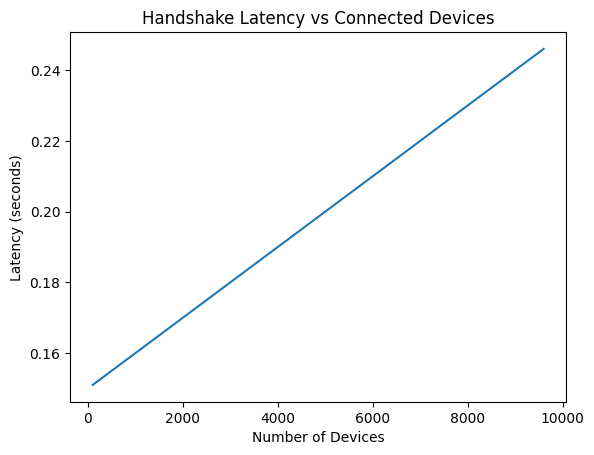

In [70]:
#Plot Latency as Devices Increase:

devices = np.arange(100, 10000, 500)
latencies = 0.15 + 0.00001 * devices  # Simulated linear increase
plt.plot(devices, latencies, label='Edge-Assisted PQC')
plt.title('Handshake Latency vs Connected Devices')
plt.xlabel('Number of Devices')
plt.ylabel('Latency (seconds)')
plt.show()


These complete processes walk you through how to:

1. Perform real-world measurements (with time, psutil, external profilers).
2. Set up local PKIs for certificate issuance.
3. Simulate thousands of IoT devices using Python threads.
4. Collect real data for post-quantum operations using liboqs. By running these examples and updating your notebook, you will create highly realistic simulations that validate your paper’s claims.